# **1. Install packages**

In [1]:
%%capture
!pip install segmentation-models-pytorch

# **2. Import libraries**

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# train test split
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import segmentation_models_pytorch as smp
from torchvision import transforms

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

import re
import utils
import classes

# warnings
import warnings
warnings.filterwarnings("ignore")

/home/icksir/miniconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **3. Load data**

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
# Total Images
IMAGE_PATH_LIST = [img for img in os.listdir("images") if img.endswith(".png")]
IMAGE_PATH_LIST = sorted_alphanumeric(IMAGE_PATH_LIST)
IMAGE_PATH_LIST = ["images/"+img for img in IMAGE_PATH_LIST]

# IMAGE_PATH = Path("images")
# IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.png"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 31


In [4]:
# Total Masks
MASK_PATH_LIST = [img for img in os.listdir("masks") if img.endswith(".png")]
MASK_PATH_LIST = sorted_alphanumeric(MASK_PATH_LIST)
MASK_PATH_LIST = ["masks/"+img for img in MASK_PATH_LIST]
# MASK_PATH = Path("masks")
# MASK_PATH_LIST = list(MASK_PATH.glob("*.png"))
# MASK_PATH_LIST = sorted(MASK_PATH_LIST)

print(f'Total Masks = {len(MASK_PATH_LIST)}')

Total Masks = 31


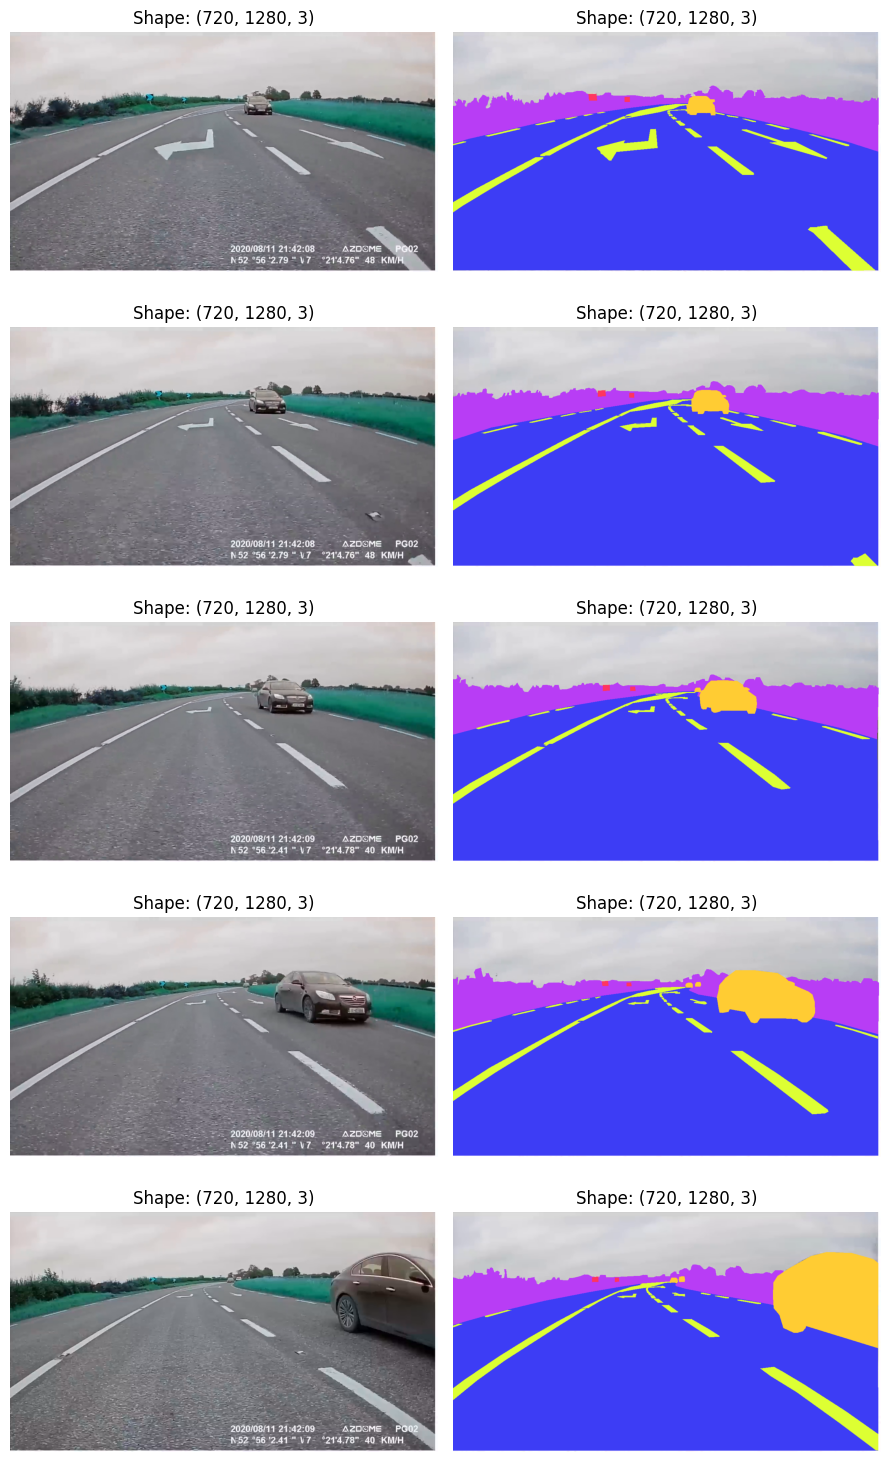

In [5]:
# We view some images with their respective masks.
fig,ax = plt.subplots(nrows = 5, ncols = 2, figsize = (9,15))

for i,(img_path, mk_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    if i>4:
        break
        
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_bgr)
    ax[i,0].axis('off')
    ax[i,0].set_title(f'Shape: {img_rgb.shape}')
    
    mask_bgr = cv2.imread(str(mk_path))
    mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(mask_rgb)
    ax[i,1].axis('off')
    ax[i,1].set_title(f'Shape: {mask_rgb.shape}')

fig.tight_layout()
fig.show()

# **4. Preprocessing**

We create a **dataframe** where we store the **image paths** and their respective **mask**.

In [6]:
images_paths = [None] * len(IMAGE_PATH_LIST)
masks_paths = [None] * len(MASK_PATH_LIST)

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST, MASK_PATH_LIST)):
    images_paths[i] = img_path
    masks_paths[i] = mask_path
    
data = pd.DataFrame({'Image':images_paths, 'Mask':masks_paths})
data.head()

,Image,Mask
0,images/0.png,masks/0.png
1,images/1.png,masks/1.png
2,images/2.png,masks/2.png
3,images/3.png,masks/3.png
4,images/4.png,masks/4.png


We divide our dataframe into 3 data sets:
- **train = 70%**
- **validation = 15%**
- **test = 15%**

In [7]:
SEED = 42

data_train, data_rest = train_test_split(data, 
                                         test_size = 0.3, 
                                         random_state = SEED)

data_val, data_test = train_test_split(data_rest, 
                                       test_size = 0.5, 
                                       random_state = SEED)

We create a **dictionary** where we have stored the **color** and its respective **id** of each class.

In [8]:
color2id = {(184, 61, 245): 0, # #b83df5: backgroud
            (255, 53, 94):1, # #ff355e: road_sign
            (255, 204, 51):2, # #ffcc33: car
            (221, 255, 51):3, # #ddff33: marking
            (61,61, 245):4} # #3d3df5: road_surface

Now we create our **Dataset's** and then **DataLoader's**.

- **Dataset**

In [11]:
RESIZE = (512, 512)

image_transforms = transforms.Compose([transforms.Resize(RESIZE), 
                                       transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE)])

In [12]:
train_dataset = classes.CustomDataset(data_train, 
                              color2id, 
                              image_transforms, 
                              mask_transforms)

val_dataset = classes.CustomDataset(data_val, 
                            color2id, 
                            image_transforms, 
                            mask_transforms)

- **DataLoader**

In [13]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = 1, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)

In [14]:
# We visualize the dimensions of a batch.
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 512, 512]))

# **5. Model**

In [15]:
# GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [166]:
# Define Model
model = smp.Unet(classes = 5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/icksir/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:09<00:00, 9.63MB/s]


In [167]:
# We visualize the architecture of our model.
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 5, 512, 512]  --                True
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                True
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] 9,408             True
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] 128               True
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                True
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] 73,984            True
│    │   

In [168]:
# We freeze the encoder layer.
for param in model.encoder.parameters():
    param.requires_grad = False

In [169]:
# We see again if the encoder layer freezes.
summary(model = model, 
        col_width = 17, 
        input_size = [1,3,512,512],
        col_names = ['input_size','output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
Unet (Unet)                                        [1, 3, 512, 512]  [1, 5, 512, 512]  --                Partial
├─ResNetEncoder (encoder)                          [1, 3, 512, 512]  [1, 3, 512, 512]  --                False
│    └─Conv2d (conv1)                              [1, 3, 512, 512]  [1, 64, 256, 256] (9,408)           False
│    └─BatchNorm2d (bn1)                           [1, 64, 256, 256] [1, 64, 256, 256] (128)             False
│    └─ReLU (relu)                                 [1, 64, 256, 256] [1, 64, 256, 256] --                --
│    └─MaxPool2d (maxpool)                         [1, 64, 256, 256] [1, 64, 128, 128] --                --
│    └─Sequential (layer1)                         [1, 64, 128, 128] [1, 64, 128, 128] --                False
│    │    └─BasicBlock (0)                         [1, 64, 128, 128] [1, 64, 128, 128] (73,984)          False
│

We define the **loss function** and the **optimizer**.

In [170]:
loss_fn = smp.losses.DiceLoss(mode = "multiclass", classes = 5, ignore_index = -1)
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

We define some functions to execute the training and another to make the predictions on new data:

- **EarlyStopping**
- **train_step**
- **val_step**
- **predictions**

In [172]:
# Define EarlyStopping
early_stopping = classes.EarlyStopping(patience = 20, delta = 0.)

In [176]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = utils.train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0174 |  Train IOU: 0.8365 |  Val Loss: 0.0971 |  Val IOU: 0.8631


  2%|▏         | 2/100 [00:32<26:31, 16.23s/it]

Epoch: 2 |  Train Loss: 0.0220 |  Train IOU: 0.9326 |  Val Loss: 0.0947 |  Val IOU: 0.8565


  3%|▎         | 3/100 [00:48<26:10, 16.19s/it]

Epoch: 3 |  Train Loss: 0.0136 |  Train IOU: 0.9094 |  Val Loss: 0.1208 |  Val IOU: 0.5812
Epoch: 4 |  Train Loss: 0.0073 |  Train IOU: 0.9125 |  Val Loss: 0.0845 |  Val IOU: 0.8546


  4%|▍         | 4/100 [01:05<26:33, 16.60s/it]

Epoch: 5 |  Train Loss: 0.0088 |  Train IOU: 0.9459 |  Val Loss: 0.0364 |  Val IOU: 0.9234


  6%|▌         | 6/100 [01:42<27:45, 17.72s/it]

Epoch: 6 |  Train Loss: 0.0093 |  Train IOU: 0.9475 |  Val Loss: 0.0540 |  Val IOU: 0.9298
Epoch: 7 |  Train Loss: 0.0031 |  Train IOU: 0.9534 |  Val Loss: 0.0113 |  Val IOU: 0.9277


  8%|▊         | 8/100 [02:20<27:57, 18.23s/it]

Epoch: 8 |  Train Loss: 0.0073 |  Train IOU: 0.9608 |  Val Loss: 0.0349 |  Val IOU: 0.9378


  9%|▉         | 9/100 [02:38<27:32, 18.16s/it]

Epoch: 9 |  Train Loss: 0.0177 |  Train IOU: 0.9542 |  Val Loss: 0.0293 |  Val IOU: 0.9512


 10%|█         | 10/100 [02:56<27:13, 18.15s/it]

Epoch: 10 |  Train Loss: 0.0032 |  Train IOU: 0.9510 |  Val Loss: 0.0495 |  Val IOU: 0.9124


 11%|█         | 11/100 [03:16<27:46, 18.73s/it]

Epoch: 11 |  Train Loss: 0.0147 |  Train IOU: 0.9606 |  Val Loss: 0.0343 |  Val IOU: 0.9327


 12%|█▏        | 12/100 [03:38<28:46, 19.62s/it]

Epoch: 12 |  Train Loss: 0.0116 |  Train IOU: 0.9638 |  Val Loss: 0.0244 |  Val IOU: 0.9510


 13%|█▎        | 13/100 [03:56<28:00, 19.32s/it]

Epoch: 13 |  Train Loss: 0.0021 |  Train IOU: 0.9573 |  Val Loss: 0.0356 |  Val IOU: 0.9402


 14%|█▍        | 14/100 [04:15<27:13, 19.00s/it]

Epoch: 14 |  Train Loss: 0.0079 |  Train IOU: 0.9615 |  Val Loss: 0.0227 |  Val IOU: 0.9385


 15%|█▌        | 15/100 [04:32<26:23, 18.63s/it]

Epoch: 15 |  Train Loss: 0.0023 |  Train IOU: 0.9574 |  Val Loss: 0.0270 |  Val IOU: 0.9098


 16%|█▌        | 16/100 [04:50<25:44, 18.39s/it]

Epoch: 16 |  Train Loss: 0.0016 |  Train IOU: 0.9637 |  Val Loss: 0.0426 |  Val IOU: 0.9249


 17%|█▋        | 17/100 [05:08<25:13, 18.23s/it]

Epoch: 17 |  Train Loss: 0.0030 |  Train IOU: 0.9647 |  Val Loss: 0.0241 |  Val IOU: 0.9564


 18%|█▊        | 18/100 [05:26<24:46, 18.13s/it]

Epoch: 18 |  Train Loss: 0.0031 |  Train IOU: 0.9696 |  Val Loss: 0.0373 |  Val IOU: 0.9566


 19%|█▉        | 19/100 [05:44<24:32, 18.18s/it]

Epoch: 19 |  Train Loss: 0.0039 |  Train IOU: 0.9659 |  Val Loss: 0.0173 |  Val IOU: 0.9234


 20%|██        | 20/100 [06:03<24:22, 18.28s/it]

Epoch: 20 |  Train Loss: 0.0007 |  Train IOU: 0.9714 |  Val Loss: 0.0224 |  Val IOU: 0.9511


 21%|██        | 21/100 [06:23<24:44, 18.79s/it]

Epoch: 21 |  Train Loss: 0.0012 |  Train IOU: 0.9666 |  Val Loss: 0.0396 |  Val IOU: 0.9429


 22%|██▏       | 22/100 [06:43<24:53, 19.15s/it]

Epoch: 22 |  Train Loss: 0.0016 |  Train IOU: 0.9614 |  Val Loss: 0.0189 |  Val IOU: 0.9561


 23%|██▎       | 23/100 [07:02<24:39, 19.21s/it]

Epoch: 23 |  Train Loss: 0.0019 |  Train IOU: 0.9643 |  Val Loss: 0.0622 |  Val IOU: 0.8921


 24%|██▍       | 24/100 [07:22<24:28, 19.32s/it]

Epoch: 24 |  Train Loss: 0.0015 |  Train IOU: 0.9648 |  Val Loss: 0.0532 |  Val IOU: 0.9314


 25%|██▌       | 25/100 [07:41<24:08, 19.32s/it]

Epoch: 25 |  Train Loss: 0.0068 |  Train IOU: 0.9711 |  Val Loss: 0.0183 |  Val IOU: 0.9509
Epoch: 26 |  Train Loss: 0.0065 |  Train IOU: 0.9687 |  Val Loss: 0.0096 |  Val IOU: 0.9370


 26%|██▌       | 26/100 [08:01<23:55, 19.40s/it]

Epoch: 27 |  Train Loss: 0.0029 |  Train IOU: 0.9684 |  Val Loss: 0.0075 |  Val IOU: 0.9519


 28%|██▊       | 28/100 [08:40<23:32, 19.62s/it]

Epoch: 28 |  Train Loss: 0.0007 |  Train IOU: 0.9739 |  Val Loss: 0.0239 |  Val IOU: 0.9526
Epoch: 29 |  Train Loss: 0.0039 |  Train IOU: 0.9725 |  Val Loss: 0.0061 |  Val IOU: 0.9624


 30%|███       | 30/100 [09:20<23:06, 19.81s/it]

Epoch: 30 |  Train Loss: 0.0046 |  Train IOU: 0.9707 |  Val Loss: 0.0201 |  Val IOU: 0.9561


 31%|███       | 31/100 [09:39<22:33, 19.62s/it]

Epoch: 31 |  Train Loss: 0.0062 |  Train IOU: 0.9770 |  Val Loss: 0.0240 |  Val IOU: 0.9725


 32%|███▏      | 32/100 [09:59<22:10, 19.56s/it]

Epoch: 32 |  Train Loss: 0.0010 |  Train IOU: 0.9786 |  Val Loss: 0.0126 |  Val IOU: 0.9721


 33%|███▎      | 33/100 [10:19<21:58, 19.69s/it]

Epoch: 33 |  Train Loss: 0.0015 |  Train IOU: 0.9811 |  Val Loss: 0.0102 |  Val IOU: 0.9688


 34%|███▍      | 34/100 [10:38<21:34, 19.61s/it]

Epoch: 34 |  Train Loss: 0.0103 |  Train IOU: 0.9740 |  Val Loss: 0.0519 |  Val IOU: 0.9321


 35%|███▌      | 35/100 [10:58<21:11, 19.57s/it]

Epoch: 35 |  Train Loss: 0.0052 |  Train IOU: 0.9705 |  Val Loss: 0.0284 |  Val IOU: 0.9520


 36%|███▌      | 36/100 [11:17<20:53, 19.58s/it]

Epoch: 36 |  Train Loss: 0.0010 |  Train IOU: 0.9717 |  Val Loss: 0.0243 |  Val IOU: 0.9651


 37%|███▋      | 37/100 [11:37<20:31, 19.55s/it]

Epoch: 37 |  Train Loss: 0.0011 |  Train IOU: 0.9782 |  Val Loss: 0.0090 |  Val IOU: 0.9795


 38%|███▊      | 38/100 [11:56<20:14, 19.58s/it]

Epoch: 38 |  Train Loss: 0.0012 |  Train IOU: 0.9726 |  Val Loss: 0.0081 |  Val IOU: 0.9406


 39%|███▉      | 39/100 [12:16<19:52, 19.54s/it]

Epoch: 39 |  Train Loss: 0.0022 |  Train IOU: 0.9770 |  Val Loss: 0.0220 |  Val IOU: 0.9315


 40%|████      | 40/100 [12:35<19:29, 19.49s/it]

Epoch: 40 |  Train Loss: 0.0011 |  Train IOU: 0.9810 |  Val Loss: 0.0321 |  Val IOU: 0.8896


 41%|████      | 41/100 [12:54<19:04, 19.39s/it]

Epoch: 41 |  Train Loss: 0.0024 |  Train IOU: 0.9818 |  Val Loss: 0.0091 |  Val IOU: 0.9635


 42%|████▏     | 42/100 [13:14<18:43, 19.36s/it]

Epoch: 42 |  Train Loss: 0.0010 |  Train IOU: 0.9830 |  Val Loss: 0.0091 |  Val IOU: 0.9653


 43%|████▎     | 43/100 [13:33<18:24, 19.38s/it]

Epoch: 43 |  Train Loss: 0.0018 |  Train IOU: 0.9805 |  Val Loss: 0.0089 |  Val IOU: 0.9282


 44%|████▍     | 44/100 [13:53<18:09, 19.45s/it]

Epoch: 44 |  Train Loss: 0.0071 |  Train IOU: 0.9747 |  Val Loss: 0.0276 |  Val IOU: 0.9680


 45%|████▌     | 45/100 [14:13<17:55, 19.56s/it]

Epoch: 45 |  Train Loss: 0.0007 |  Train IOU: 0.9831 |  Val Loss: 0.0109 |  Val IOU: 0.9749


 46%|████▌     | 46/100 [14:32<17:34, 19.52s/it]

Epoch: 46 |  Train Loss: 0.0033 |  Train IOU: 0.9810 |  Val Loss: 0.0078 |  Val IOU: 0.9735


 47%|████▋     | 47/100 [14:51<17:09, 19.43s/it]

Epoch: 47 |  Train Loss: 0.0015 |  Train IOU: 0.9869 |  Val Loss: 0.0356 |  Val IOU: 0.9544
Epoch: 48 |  Train Loss: 0.0006 |  Train IOU: 0.9882 |  Val Loss: 0.0047 |  Val IOU: 0.9517


 49%|████▉     | 49/100 [15:30<16:31, 19.43s/it]

Epoch: 49 |  Train Loss: 0.0005 |  Train IOU: 0.9853 |  Val Loss: 0.0204 |  Val IOU: 0.9695


 50%|█████     | 50/100 [15:51<16:25, 19.71s/it]

Epoch: 50 |  Train Loss: 0.0006 |  Train IOU: 0.9891 |  Val Loss: 0.0041 |  Val IOU: 0.9632


 51%|█████     | 51/100 [16:11<16:10, 19.80s/it]

Epoch: 51 |  Train Loss: 0.0019 |  Train IOU: 0.9882 |  Val Loss: 0.0125 |  Val IOU: 0.9636


 52%|█████▏    | 52/100 [16:30<15:51, 19.82s/it]

Epoch: 52 |  Train Loss: 0.0027 |  Train IOU: 0.9877 |  Val Loss: 0.0194 |  Val IOU: 0.9284


 53%|█████▎    | 53/100 [16:50<15:33, 19.86s/it]

Epoch: 53 |  Train Loss: 0.0010 |  Train IOU: 0.9836 |  Val Loss: 0.0308 |  Val IOU: 0.9301


 54%|█████▍    | 54/100 [17:11<15:20, 20.00s/it]

Epoch: 54 |  Train Loss: 0.0040 |  Train IOU: 0.9761 |  Val Loss: 0.0524 |  Val IOU: 0.9342


 55%|█████▌    | 55/100 [17:30<14:51, 19.81s/it]

Epoch: 55 |  Train Loss: 0.0015 |  Train IOU: 0.9755 |  Val Loss: 0.0404 |  Val IOU: 0.9456


 56%|█████▌    | 56/100 [17:49<14:23, 19.63s/it]

Epoch: 56 |  Train Loss: 0.0014 |  Train IOU: 0.9838 |  Val Loss: 0.0185 |  Val IOU: 0.9532


 57%|█████▋    | 57/100 [18:08<13:59, 19.52s/it]

Epoch: 57 |  Train Loss: 0.0012 |  Train IOU: 0.9850 |  Val Loss: 0.0066 |  Val IOU: 0.9774


 58%|█████▊    | 58/100 [18:28<13:41, 19.56s/it]

Epoch: 58 |  Train Loss: 0.0015 |  Train IOU: 0.9870 |  Val Loss: 0.0055 |  Val IOU: 0.9690


 59%|█████▉    | 59/100 [18:48<13:21, 19.54s/it]

Epoch: 59 |  Train Loss: 0.0008 |  Train IOU: 0.9762 |  Val Loss: 0.0550 |  Val IOU: 0.8597


 60%|██████    | 60/100 [19:07<12:58, 19.46s/it]

Epoch: 60 |  Train Loss: 0.0102 |  Train IOU: 0.9790 |  Val Loss: 0.0262 |  Val IOU: 0.9662


 61%|██████    | 61/100 [19:26<12:39, 19.46s/it]

Epoch: 61 |  Train Loss: 0.0009 |  Train IOU: 0.9819 |  Val Loss: 0.0128 |  Val IOU: 0.9332


 62%|██████▏   | 62/100 [19:46<12:16, 19.38s/it]

Epoch: 62 |  Train Loss: 0.0013 |  Train IOU: 0.9829 |  Val Loss: 0.0056 |  Val IOU: 0.9624


 63%|██████▎   | 63/100 [20:05<11:59, 19.44s/it]

Epoch: 63 |  Train Loss: 0.0021 |  Train IOU: 0.9842 |  Val Loss: 0.0077 |  Val IOU: 0.9643


 64%|██████▍   | 64/100 [20:25<11:45, 19.60s/it]

Epoch: 64 |  Train Loss: 0.0008 |  Train IOU: 0.9822 |  Val Loss: 0.0208 |  Val IOU: 0.9603
Epoch: 65 |  Train Loss: 0.0029 |  Train IOU: 0.9879 |  Val Loss: 0.0036 |  Val IOU: 0.9804


 66%|██████▌   | 66/100 [21:04<11:05, 19.59s/it]

Epoch: 66 |  Train Loss: 0.0031 |  Train IOU: 0.9855 |  Val Loss: 0.0084 |  Val IOU: 0.9421


 67%|██████▋   | 67/100 [21:24<10:46, 19.60s/it]

Epoch: 67 |  Train Loss: 0.0011 |  Train IOU: 0.9864 |  Val Loss: 0.0094 |  Val IOU: 0.9742


 68%|██████▊   | 68/100 [21:44<10:28, 19.65s/it]

Epoch: 68 |  Train Loss: 0.0023 |  Train IOU: 0.9893 |  Val Loss: 0.0954 |  Val IOU: 0.8684


 69%|██████▉   | 69/100 [22:03<10:08, 19.64s/it]

Epoch: 69 |  Train Loss: 0.0011 |  Train IOU: 0.9835 |  Val Loss: 0.0145 |  Val IOU: 0.9371


 70%|███████   | 70/100 [22:23<09:52, 19.74s/it]

Epoch: 70 |  Train Loss: 0.0038 |  Train IOU: 0.9761 |  Val Loss: 0.0208 |  Val IOU: 0.9497


 71%|███████   | 71/100 [22:43<09:33, 19.79s/it]

Epoch: 71 |  Train Loss: 0.0021 |  Train IOU: 0.9784 |  Val Loss: 0.0347 |  Val IOU: 0.9506


 72%|███████▏  | 72/100 [23:03<09:13, 19.78s/it]

Epoch: 72 |  Train Loss: 0.0007 |  Train IOU: 0.9852 |  Val Loss: 0.0114 |  Val IOU: 0.9516


 73%|███████▎  | 73/100 [23:22<08:50, 19.64s/it]

Epoch: 73 |  Train Loss: 0.0005 |  Train IOU: 0.9863 |  Val Loss: 0.0307 |  Val IOU: 0.9626


 74%|███████▍  | 74/100 [23:42<08:27, 19.51s/it]

Epoch: 74 |  Train Loss: 0.0006 |  Train IOU: 0.9892 |  Val Loss: 0.0053 |  Val IOU: 0.9723
Epoch: 75 |  Train Loss: 0.0007 |  Train IOU: 0.9907 |  Val Loss: 0.0034 |  Val IOU: 0.9624


 76%|███████▌  | 76/100 [24:23<08:07, 20.29s/it]

Epoch: 76 |  Train Loss: 0.0015 |  Train IOU: 0.9902 |  Val Loss: 0.0045 |  Val IOU: 0.9593


 77%|███████▋  | 77/100 [24:42<07:36, 19.83s/it]

Epoch: 77 |  Train Loss: 0.0005 |  Train IOU: 0.9860 |  Val Loss: 0.0065 |  Val IOU: 0.9502


 78%|███████▊  | 78/100 [25:02<07:15, 19.79s/it]

Epoch: 78 |  Train Loss: 0.0013 |  Train IOU: 0.9844 |  Val Loss: 0.0116 |  Val IOU: 0.9783


 79%|███████▉  | 79/100 [25:18<06:34, 18.77s/it]

Epoch: 79 |  Train Loss: 0.0013 |  Train IOU: 0.9799 |  Val Loss: 0.0058 |  Val IOU: 0.9625


 80%|████████  | 80/100 [25:38<06:23, 19.16s/it]

Epoch: 80 |  Train Loss: 0.0007 |  Train IOU: 0.9858 |  Val Loss: 0.0304 |  Val IOU: 0.9680
Epoch: 81 |  Train Loss: 0.0005 |  Train IOU: 0.9890 |  Val Loss: 0.0025 |  Val IOU: 0.9722


 82%|████████▏ | 82/100 [26:19<05:57, 19.84s/it]

Epoch: 82 |  Train Loss: 0.0004 |  Train IOU: 0.9903 |  Val Loss: 0.0133 |  Val IOU: 0.9789


 83%|████████▎ | 83/100 [26:42<05:55, 20.91s/it]

Epoch: 83 |  Train Loss: 0.0007 |  Train IOU: 0.9920 |  Val Loss: 0.0028 |  Val IOU: 0.9804


 84%|████████▍ | 84/100 [27:04<05:38, 21.18s/it]

Epoch: 84 |  Train Loss: 0.0018 |  Train IOU: 0.9904 |  Val Loss: 0.0034 |  Val IOU: 0.9621


 85%|████████▌ | 85/100 [27:26<05:20, 21.38s/it]

Epoch: 85 |  Train Loss: 0.0011 |  Train IOU: 0.9901 |  Val Loss: 0.0100 |  Val IOU: 0.9641


 86%|████████▌ | 86/100 [27:48<05:00, 21.49s/it]

Epoch: 86 |  Train Loss: 0.0022 |  Train IOU: 0.9886 |  Val Loss: 0.0134 |  Val IOU: 0.9532


 87%|████████▋ | 87/100 [28:09<04:37, 21.38s/it]

Epoch: 87 |  Train Loss: 0.0007 |  Train IOU: 0.9878 |  Val Loss: 0.0074 |  Val IOU: 0.9157


 88%|████████▊ | 88/100 [28:33<04:26, 22.18s/it]

Epoch: 88 |  Train Loss: 0.0010 |  Train IOU: 0.9848 |  Val Loss: 0.0171 |  Val IOU: 0.9395


 89%|████████▉ | 89/100 [28:55<04:02, 22.06s/it]

Epoch: 89 |  Train Loss: 0.0019 |  Train IOU: 0.9783 |  Val Loss: 0.0176 |  Val IOU: 0.9639


 90%|█████████ | 90/100 [29:14<03:32, 21.25s/it]

Epoch: 90 |  Train Loss: 0.0044 |  Train IOU: 0.9772 |  Val Loss: 0.0754 |  Val IOU: 0.8729


 91%|█████████ | 91/100 [29:35<03:09, 21.03s/it]

Epoch: 91 |  Train Loss: 0.0014 |  Train IOU: 0.9747 |  Val Loss: 0.0223 |  Val IOU: 0.9624


 92%|█████████▏| 92/100 [29:56<02:49, 21.17s/it]

Epoch: 92 |  Train Loss: 0.0007 |  Train IOU: 0.9845 |  Val Loss: 0.0101 |  Val IOU: 0.9774


 93%|█████████▎| 93/100 [30:16<02:25, 20.73s/it]

Epoch: 93 |  Train Loss: 0.0013 |  Train IOU: 0.9882 |  Val Loss: 0.0361 |  Val IOU: 0.9613


 94%|█████████▍| 94/100 [30:34<01:59, 19.94s/it]

Epoch: 94 |  Train Loss: 0.0005 |  Train IOU: 0.9886 |  Val Loss: 0.0025 |  Val IOU: 0.9637


 95%|█████████▌| 95/100 [30:52<01:36, 19.29s/it]

Epoch: 95 |  Train Loss: 0.0005 |  Train IOU: 0.9907 |  Val Loss: 0.0288 |  Val IOU: 0.9667


 96%|█████████▌| 96/100 [31:11<01:16, 19.18s/it]

Epoch: 96 |  Train Loss: 0.0004 |  Train IOU: 0.9916 |  Val Loss: 0.0128 |  Val IOU: 0.9653


 97%|█████████▋| 97/100 [31:28<00:56, 18.82s/it]

Epoch: 97 |  Train Loss: 0.0006 |  Train IOU: 0.9930 |  Val Loss: 0.0035 |  Val IOU: 0.9786


 98%|█████████▊| 98/100 [31:48<00:38, 19.13s/it]

Epoch: 98 |  Train Loss: 0.0003 |  Train IOU: 0.9933 |  Val Loss: 0.0063 |  Val IOU: 0.9713


 99%|█████████▉| 99/100 [32:08<00:19, 19.25s/it]

Epoch: 99 |  Train Loss: 0.0005 |  Train IOU: 0.9934 |  Val Loss: 0.0026 |  Val IOU: 0.9728
Epoch: 100 |  Train Loss: 0.0003 |  Train IOU: 0.9941 |  Val Loss: 0.0023 |  Val IOU: 0.9787


100%|██████████| 100/100 [32:27<00:00, 19.48s/it]


: 

In [17]:
utils.loss_and_metric_plot(RESULTS)

NameError: name 'RESULTS' is not defined

# **6. Evaluation metric**

- **Predictions**

Just as we did with our training and validation data we are going to create our **Dataset** and **DataLoader** for our **test set**.

In [17]:
test_dataset = classes.CustomDataset(data_test, color2id, image_transforms, mask_transforms)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)

In [46]:
data_test = pd.DataFrame(data={'Image': ["test_image_512.png"], 'Mask': ['test_mask_512.png']})

image = cv2.imread("images/2.png")
image = cv2.resize(image, (720,720))
cv2.imwrite("test_image_512.png", image)

image = cv2.imread("masks/2.png")
image = cv2.resize(image, (512,512))
cv2.imwrite("test_mask_512.png", image)

True

In [45]:
data_test

,Image,Mask
12,images/12.png,masks/12.png
15,images/15.png,masks/15.png
9,images/9.png,masks/9.png
27,images/27.png,masks/27.png
24,images/24.png,masks/24.png


(-0.5, 511.5, 511.5, -0.5)

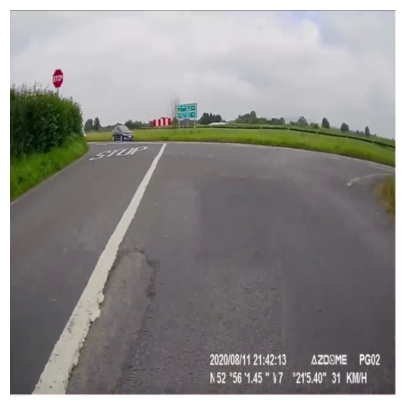

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,10))
ax.imshow(test_dataset.__getitem__(1)[0].permute(1, 2, 0).detach().cpu().numpy())
ax.axis('off')

In [20]:
pred_mask_test = utils.predictions(test_dataloader, "program/best_model.pth")

100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


In [21]:
# We are going to create our tensors so we can plot later.
IMAGE_TEST = []
MASK_TEST = []

for img,mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)

MASK_TEST = torch.cat(MASK_TEST)

- **IOU**

In [22]:
TP, FP, FN, TN = smp.metrics.get_stats(output = pred_mask_test.long(), 
                                       target = MASK_TEST.long(), 
                                       mode = "multiclass", 
                                       ignore_index = -1, 
                                       num_classes = 5)

In [23]:
iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction = "micro")
print(f'IOU Test = {iou_test:.4f}')

IOU Test = 0.9909
